In [ ]:
import pandas as pd
import numpy as np
import sklearn.model_selection as skms
import sklearn.preprocessing as skpp

import gensim
import gensim.models.doc2vec as d2v

import nltk

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip

--2021-07-27 22:46:43--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 52.84.169.45, 52.84.169.118, 52.84.169.30, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|52.84.169.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363199356 (346M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>] 346.37M   146MB/s    in 2.4s    

2021-07-27 22:46:45 (146 MB/s) - ‘complaints.csv.zip’ saved [363199356/363199356]



In [ ]:
!unzip complaints.csv.zip

Archive:  complaints.csv.zip
  inflating: complaints.csv          


In [ ]:
!ls -l

total 1741348
-rw-r--r-- 1 root root 1419931531 Jul 27 04:19 complaints.csv
-rw-r--r-- 1 root root  363199356 Jul 27 08:26 complaints.csv.zip
drwxr-xr-x 1 root root       4096 Jul 16 13:20 sample_data


In [ ]:
data = pd.read_csv("complaints.csv")
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
2,2021-07-12,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,NaN,NaN,DISCOVER BANK,CA,953XX,NaN,NaN,Web,2021-07-12,In progress,Yes,NaN,4534953
3,2021-07-25,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",SC,29341,NaN,NaN,Web,2021-07-25,In progress,Yes,NaN,4572854
4,2021-07-14,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,"Law Office of Michael J. Scott, PC",VA,22485,NaN,NaN,Web,2021-07-14,Closed with explanation,Yes,NaN,4543119


In [ ]:
xnombre = "Consumer complaint narrative"
ynombre = "Product"
data = data[[xnombre,ynombre]]
data.shape

(2190954, 2)

In [ ]:

#limpieza de los datos
data = data.dropna()
data.shape

(754692, 2)

In [ ]:
data = data[data[xnombre].apply(len)>1000]
data[data[xnombre].apply(len)>1000].shape

(262351, 2)

In [ ]:
data.iloc[0,0]

'Signed up for the Amazon Credit Card as they heavily advertise it. Upon being approved for the card they allowed me to start using it before the card was physically mailed to my house. Unfortunately, you can not signup for auto-bill pay or register an account with the website until the card physically arrives at my doorstep. \n\nNo problem, a few weeks later it arrives, I create a login on the website and immediately sign up for Automatic Bill Payment. This is done successfully and I quadruple check that my payments pay off the full balance ( not just minimum ) during each statement ( like I do with all my accounts ). \n\nToday, XX/XX/XXXX, I found out my payments were being declined. The Synchrony Banking websites are all broken, and all seem to take you to different portals so I called the 800 number. They confirmed that I signed up for auto-pay but they said " some \'\' payments ( especially the first ) will not always be automatically billed and need to be manually submitted. Thus

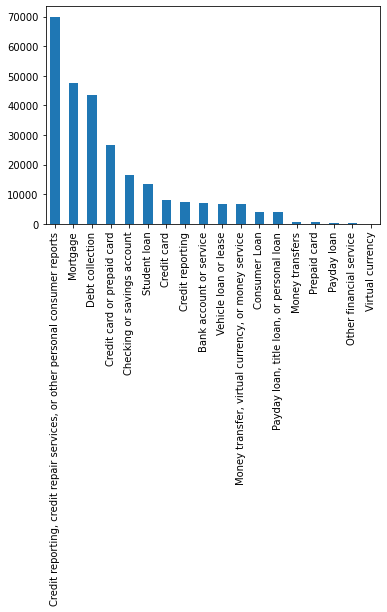

In [ ]:
data[ynombre].value_counts().plot(kind = "bar")

In [ ]:
data[ynombre].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    69932
Mortgage                                                                        47418
Debt collection                                                                 43331
Credit card or prepaid card                                                     26469
Checking or savings account                                                     16362
Student loan                                                                    13446
Credit card                                                                      8055
Credit reporting                                                                 7453
Bank account or service                                                          7083
Vehicle loan or lease                                                            6683
Money transfer, virtual currency, or money service                               6634
Consumer Loan                                         

In [ ]:
print(data.shape)

conteo = data[ynombre].value_counts()
conteo = conteo[conteo < 5000]

for idx in conteo.index: #menores de 5000
  data = data[data[ynombre] != idx] #me quedo con los mayores de 5000

print(data.shape)

(262351, 2)
(252866, 2)


In [ ]:
tmp = data[0:0]

for idx in data[ynombre].value_counts().index:
  tmp = tmp.append(data[data[ynombre] == idx][:5000])

print(tmp.shape)

(55000, 2)


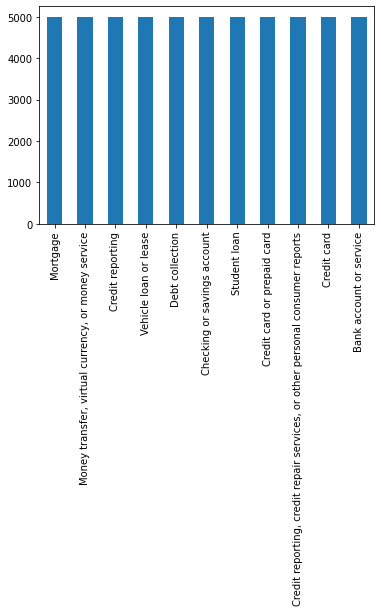

In [ ]:
tmp[ynombre].value_counts().plot(kind="bar")

In [ ]:
data = tmp

In [ ]:
data_train, data_test = skms.train_test_split(data,test_size=0.3, random_state=0)

In [ ]:
def EtiquetarDocumento(fila):
  return d2v.TaggedDocument(
      words = nltk.word_tokenize(fila[xnombre]),
      tags=[fila[ynombre]]
  )

In [ ]:
data_train_tagged = data_train.apply(EtiquetarDocumento,axis=1)
data_test_tagged = data_test.apply(EtiquetarDocumento,axis=1)

In [ ]:
modelo_DBoW = d2v.Doc2Vec(dm=0,vector_size=300, min_count=2)

In [ ]:
modelo_DBoW.build_vocab(data_train_tagged)

In [ ]:
modelo_DBoW.train(data_train_tagged,epochs=40,total_examples=modelo_DBoW.corpus_count)

In [ ]:
modelo_DBoW.most_similar("credit")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sick..', 0.21025316417217255),
 ('glued', 0.21001872420310974),
 ('momey', 0.2099083960056305),
 ('havr', 0.20659349858760834),
 ('BEGGED', 0.20609404146671295),
 ('Navient', 0.20585450530052185),
 ('Hondas', 0.20307016372680664),
 ('9/10', 0.19974559545516968),
 ('Elder', 0.1984102427959442),
 ('10.6', 0.19559364020824432)]

In [ ]:
data_train_tagged.values[0].tags

['Checking or savings account']

In [ ]:
len(modelo_DBoW.infer_vector(data_train_tagged.values[0].words))

300

In [ ]:
def GenerarVectores(modelo, tagged_data):
  x = [modelo.infer_vector(d.words, steps=30) for d in tagged_data.values]
  y = [d.tags[0] for d in tagged_data.values]
  return (x,y)  

In [ ]:
xtest, ytest = GenerarVectores(modelo_DBoW, data_test_tagged)
xtrain, ytrain = GenerarVectores(modelo_DBoW, data_train_tagged)

In [ ]:
yencoder = skpp.LabelEncoder()
yencoder.fit(ytrain)

LabelEncoder()

In [ ]:
import sklearn.linear_model as sklm

In [ ]:
modelo_lr = sklm.LogisticRegression(C=0.001, random_state=0)
modelo_lr.fit(xtrain,yencoder.transform(ytrain))
modelo_lr.score(xtest,yencoder.transform(ytest))

0.7643030303030303

In [ ]:
import sklearn.svm as skvm

In [ ]:
modelo_svm = skvm.SVC(kernel="linear")
modelo_svm.fit(xtrain,yencoder.transform(ytrain))
modelo_svm.score(xtest,yencoder.transform(ytest))

0.7292727272727273

In [ ]:
len(tmp[ynombre].value_counts())

11

In [ ]:
import keras as ke

In [ ]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)

In [ ]:
from keras.utils import np_utils
ytrain_e = np_utils.to_categorical( np.array( yencoder.transform(ytrain) ) )
ytest_e = np_utils.to_categorical( np.array( yencoder.transform(ytest) ) )

In [ ]:
modelo_nn = ke.models.Sequential()
modelo_nn.add(ke.layers.InputLayer(input_shape=(300,)))
modelo_nn.add(ke.layers.Dense(150, activation="relu"))
modelo_nn.add(ke.layers.Dropout(0.2))
modelo_nn.add(ke.layers.Dense(150, activation="relu"))
modelo_nn.add(ke.layers.Dropout(0.2))
modelo_nn.add(ke.layers.Dense(50,activation="relu"))
modelo_nn.add(ke.layers.Dropout(0.2))
modelo_nn.add(ke.layers.Dense(13,activation="softmax"))
modelo_nn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
modelo_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                7550      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 13)               

In [ ]:
modelo_nn.fit(xtrain, ytrain_e, batch_size=5000, epochs=30, validation_data=(xtest,ytest_e))